In [203]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
# Wordcloud libraries
from wordcloud import WordCloud, STOPWORDS
import re
from PIL import Image

# Visualisation libraries
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [126]:
# Load dataset
data = pd.read_csv('ny_accidents.csv', na_values='?')

In [127]:
# Functions: Farenheit to Celcius, miles to kilometers, and inches to millimeters
def farenheit_to_celsius(farenheit): 
    return ((farenheit - 32) * (5/9)) 
def mile_to_km(mile): 
    return (mile*1.609344)
def inch_to_mm(inch): 
    return (inch*25.4)

In [128]:
# Drop 'Number', and other attributes that are not used in our analysis
cols = ['Unnamed: 0','Number', 'Airport_Code', 'Timezone', 'Country', 'State', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Turning_Loop']
data.drop(cols, axis=1, inplace=True)

In [129]:
# Drop duplicates
data.drop_duplicates()
data.dropna(inplace = True)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36779 entries, 0 to 39536
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36779 non-null  object 
 1   Severity           36779 non-null  int64  
 2   Start_Time         36779 non-null  object 
 3   End_Time           36779 non-null  object 
 4   Start_Lat          36779 non-null  float64
 5   Start_Lng          36779 non-null  float64
 6   End_Lat            36779 non-null  float64
 7   End_Lng            36779 non-null  float64
 8   Distance.mi.       36779 non-null  float64
 9   Description        36779 non-null  object 
 10  Street             36779 non-null  object 
 11  Side               36779 non-null  object 
 12  City               36779 non-null  object 
 13  County             36779 non-null  object 
 14  Zipcode            36779 non-null  object 
 15  Weather_Timestamp  36779 non-null  object 
 16  Temperature.F.     367

In [132]:
# Make list of variables
points_of_interest = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

In [133]:
# Conversion to datetime type
attributes = ['Start_Time','End_Time','Weather_Timestamp']
data[attributes] = data[attributes].apply(pd.to_datetime, errors='coerce')

In [134]:
# Conversion of Imperial System (Fahrenheit, mile, inch) to Metric System (Celsius, kilometre, millimetre)
data[['Temperature.F.', 'Wind_Chill.F.']] = data[['Temperature.F.', 'Wind_Chill.F.']].apply(farenheit_to_celsius)
data[['Visibility.mi.', 'Wind_Speed.mph.']] = data[['Visibility.mi.', 'Wind_Speed.mph.']].apply(mile_to_km)
data['Precipitation.in.'] = data['Precipitation.in.'].apply(inch_to_mm)

In [135]:
# Severity attribute
SeverityLevels = [ data['Severity'] == 1, data['Severity'] == 2, data['Severity'] == 3, data['Severity'] == 4 ]
Lables = ['Low','Medium','High','Very High']
data['SeverityLevels'] = np.select(SeverityLevels, Lables, default=np.nan)

In [136]:
# weekday attribute
data['Weekday'] = data['Start_Time'].dt.dayofweek

In [137]:
# month attribute
data['Month'] = data['Start_Time'].dt.month

In [138]:
# season category
situations = (data.Month < 3, data.Month < 5, data.Month < 8, data.Month <12, data.Month == 12)
lables = ['winter', 'spring','summer', 'fall', 'winter']
data['Season'] = np.select(situations, lables, default=np.nan)

In [139]:
# year attribute
data['Year'] = data['Start_Time'].dt.year

In [140]:
# highway attribute
keywords = ['Pkwy', 'Parkway', 'I-', 'Interstate', 'Expy', 'Exp', 'Expressway', 'Route', 'State', 'NY', 'Trwy', 'Throughway', 'US', 'Hwy', 'Highway', 'Wyck', '9n']
data['Highway'] = False
data.loc[data['Street'].str.contains('|'.join(keywords), case = False) == True, 'Highway'] = True

In [141]:
# incident duration attribute
data['Duration'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds().div(60).astype(int)

In [142]:
# weather condition attribute
Weather_Situation = [data['Weather_Condition'].str.contains('Clear|Fair', case=False) == True,
data['Weather_Condition'].str.contains('Cloud|Overcast', case=False) == True,
data['Weather_Condition'].str.contains('Rain|Storm', case=False) == True,
data['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False) == True,
data['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False) == True,
data['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False) == True,
data['Weather_Condition'].str.contains('Fog', case=False) == True]
Labels = ['Clear', 'Cloud', 'Rain', 'Heavy_rain', 'Snow', 'Heavy_Snow','Fog']
data['Weather_Condition'] = np.select(Weather_Situation, Labels, default='Other')

In [143]:
# Traffic calming presence attribute
data['Traffic_Calming_Presence'] = data['Traffic_Calming']
data['Traffic_Calming_Presence'] = np.where(data.Bump == True, False, data['Traffic_Calming_Presence'])

In [144]:
# points_of_interest presence attribute
data['points_of_interest_Presence'] = data[points_of_interest].any(axis=1)

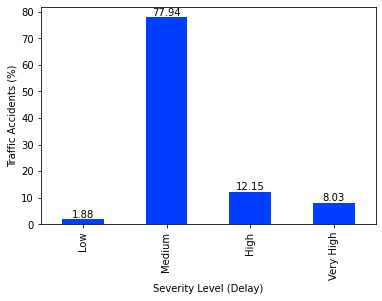

In [152]:
# To identify the percentage of accidents caused by different severity levels
severity_proportion = pd.DataFrame()
severity_proportion['count'] = data['Severity'].groupby(data['Severity']).count()
severity_proportion['percent'] = (severity_proportion['count'] / severity_proportion['count'].sum())*100
ax = severity_proportion['percent'].plot(kind='bar', xlabel='Severity Level (Delay)', ylabel='Traffic Accidents (%)', colormap=ListedColormap(sns.color_palette('bright')))
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")                                         
ax.set_xticklabels(['Low','Medium','High','Very High'])
plt.show()

In [161]:
# To identify the relation between the distance and the occurance of the accident
data.rename(columns = {'Distance.mi.':'Distance'}, inplace=True) # First, we renamed Distance.mi. to Distance
data['Duration'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds().div(60).astype(int) #incident duration
#fig.set_figheight(4)
#fig.set_figwidth(9)
#sns.boxplot(x='Distance', data=data, palette='bright', showfliers=False)
#fig.tight_layout()

In [162]:
data_nyc = pd.DataFrame(data.drop(data.columns[[3, 4, 14]], axis = 1).drop_duplicates().dropna())

In [163]:
data_nyc["Start_Time"] = pd.to_datetime(data_nyc["Start_Time"], errors="coerce")

test statistic U = 99775645.5000; p-value = 4.5230e-270


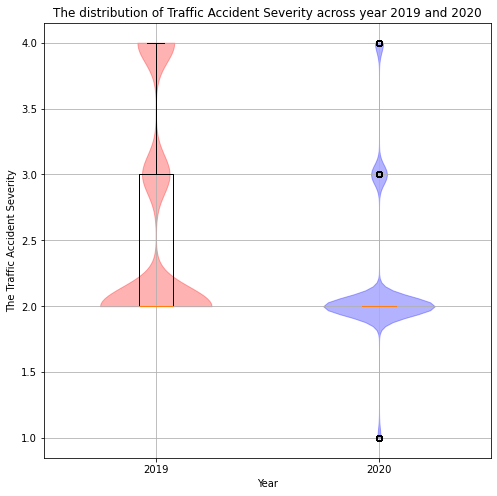

In [164]:
# To creat column for year
data['Year'] = data['Start_Time'].dt.year
# To conduct Wilcoxon-Mann-Whitney U test
stat, p = stats.mannwhitneyu(x=data[data['Year']==2019]['Severity'], y=data[data['Year']==2020]['Severity'])
print("test statistic U = {:.4f}; p-value = {:.4e}".format(stat, p))
# To plot Violin of distribution of traffic accident severity across the year 2019 and 2020
plotlabels = [2019, 2020]
plotdata = [data[data['Year']==label]['Severity'] for label in plotlabels]
colors = ['red','blue']
plt.figure(figsize=(8, 8))
vparts = plt.violinplot(plotdata, showextrema=False)
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color)
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels)
plt.xlabel('Year')
plt.ylabel('The Traffic Accident Severity')
plt.title('The distribution of Traffic Accident Severity across year 2019 and 2020')
plt.grid(zorder=0)
plt.show()

In [165]:
num_dd = ['Distance','Duration'] # weather columns containing numerical variables
data_dd = data[num_dd].describe().T
data_dd = pd.concat([data_dd, data[num_dd].skew()], axis=1).rename(columns={0:'Skewness'})
data_dd = pd.concat([data_dd, data[num_dd].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(data_dd)

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Distance,36779.0,0.652764,1.568438,0.0,0.0,0.186,0.683,49.24,8.658814,136.201140
Duration,36779.0,219.106447,3607.495386,5.0,41.0,79.000,147.000,224923.00,58.803103,3552.674843


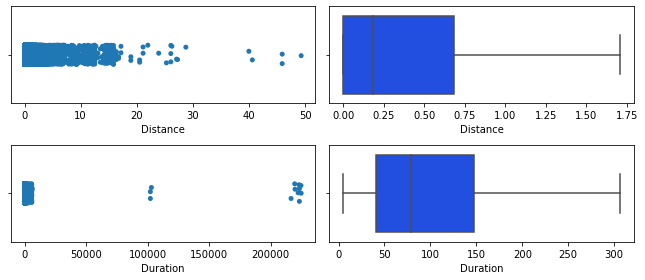

In [166]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4)
fig.set_figwidth(9)
sns.stripplot(ax = ax[0,0], x='Distance', data=data)
sns.boxplot(ax = ax[0,1], x='Distance', data=data, palette='bright', showfliers=False)
sns.stripplot(ax = ax[1,0], x='Duration', data=data)
sns.boxplot(ax = ax[1,1], x='Duration', data=data, palette='bright', showfliers=False)
fig.tight_layout()

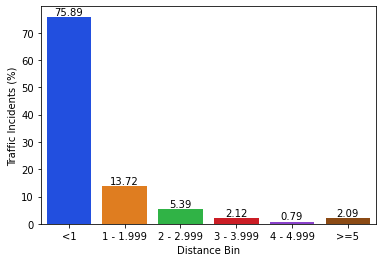

In [167]:
# To demonstrate the percentage of traffic incidents across the distances
distance_prop = pd.cut(data['Distance'], bins=[0, 1, 2, 3, 4, 5, np.inf], labels=['<1','1 - 1.999','2 - 2.999', '3 - 3.999', '4 - 4.999', '>=5']).reset_index().groupby('Distance').count()
distance_prop = pd.DataFrame(distance_prop.reset_index().values)
distance_prop.set_axis(['distance_bin','count'], axis=1, inplace=True)
distance_prop['percent'] = distance_prop['count'].apply(lambda x: x / distance_prop['count'].sum() * 100)
ax = sns.barplot(x='distance_bin', y='percent', data=distance_prop, palette = 'bright')
ax.set(title='', xlabel="Distance Bin", ylabel="Traffic Incidents (%)")
for container in ax.containers: 
    ax.bar_label(container, fmt= "%.2f") 
plt.show()

In [173]:
# , Humidity... to Humidity, 
data.rename(columns = {'Temperature.F.':'Temperature'}, inplace=True) #First, we renamed Temperature.F. to Temperature
data.rename(columns = {'Humidity...':'Humidity'}, inplace=True) #We renamed Humidity... to Humidity
data.rename(columns = {'Pressure.in.':'Pressure'}, inplace=True) #We renamed Pressure.in. to Pressure
data.rename(columns = {'Wind_Speed.mph.':'Wind_Speed'}, inplace=True) #We renamed Wind_Speed.mph. to Wind_Speed
data.rename(columns = {'Precipitation.in.':'Precipitation'}, inplace=True) #We renamed Precipitation.in. to Precipitation
data.rename(columns = {'Wind_Chill.F.':'Wind_Chill'}, inplace=True) #We renamed Wind_Speed.mph. to Wind_Speed
# To demonstrate attributes associated with weather
weather_attributes = ['Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Wind_Speed','Precipitation']
data_weather_stats = data[weather_attributes].describe().T
data_weather_stats = pd.concat([data_weather_stats, data[weather_attributes].skew()], axis=1).rename(columns={0:'Skewness'})
data_weather_stats = pd.concat([data_weather_stats, data[weather_attributes].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(data_weather_stats)

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Temperature,36779.0,11.406455,9.183141,-24.444444,4.444444,11.111111,18.333333,35.555556,0.029298,-0.539257
Wind_Chill,36779.0,9.997925,10.708228,-34.666667,1.666667,11.111111,18.333333,35.555556,-0.146442,-0.677639
Humidity,36779.0,66.184317,20.529978,13.000000,50.000000,68.000000,84.000000,100.000000,-0.222074,-0.998858
Pressure,36779.0,29.694968,0.392098,27.550000,29.450000,29.720000,29.970000,30.710000,-0.726206,1.505635
Wind_Speed,36779.0,14.601720,9.434961,0.000000,8.046720,12.874752,20.921472,64.373760,0.678783,0.736284
Precipitation,36779.0,0.134055,0.701003,0.000000,0.000000,0.000000,0.000000,21.082000,10.237166,149.763439


<AxesSubplot:xlabel='Temperature', ylabel='Count'>

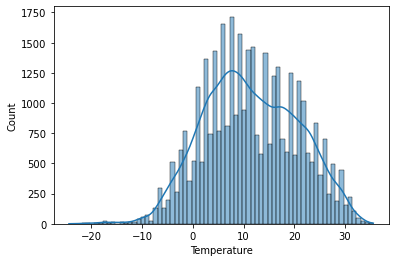

In [183]:
# To draw a histogram
Temperature = data['Temperature']
sns.histplot(data = Temperature, kde = True)

<AxesSubplot:xlabel='Humidity', ylabel='Count'>

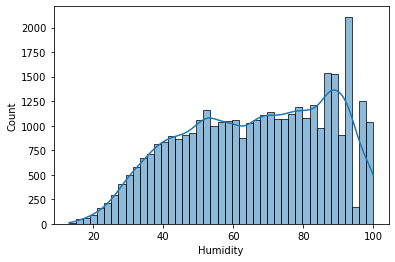

In [180]:
humidity = data['Humidity']
sns.histplot(data = humidity, kde = True)

<AxesSubplot:xlabel='Pressure', ylabel='Count'>

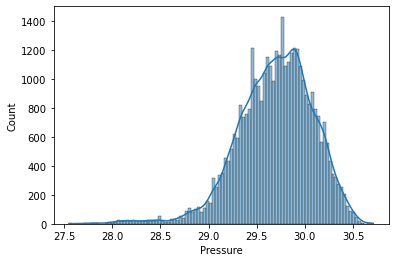

In [181]:
Pressure = data['Pressure']
sns.histplot(data = Pressure, kde = True)

<AxesSubplot:xlabel='Wind_Speed', ylabel='Count'>

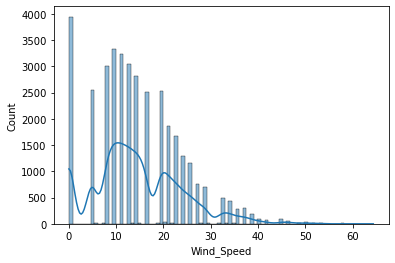

In [182]:
Wind_speed = data['Wind_Speed']
sns.histplot(data = Wind_speed, kde = True)

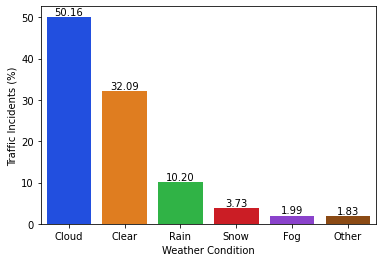

In [188]:
# To analyse the distribution of number of accident across different weather conditions
plot_order = data.groupby('Weather_Condition')['Weather_Condition'].count().sort_values(ascending=False).index.values
ax = sns.barplot(x='Weather_Condition', y='Severity', data=data, estimator=lambda x: len(x) / len(data) * 100 ,order=plot_order, palette = 'bright')
ax.set(title='', xlabel="Weather Condition", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

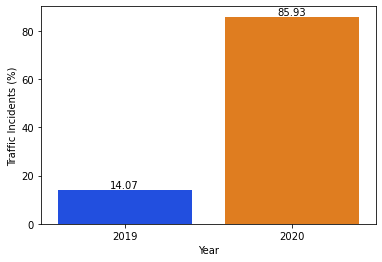

In [190]:
# To draw the distribution of percentage of traffic incidents across the year 2019 and 2020
ax = sns.barplot(x='Year', y='Year', data=data, estimator=lambda x: len(x) / len(data) * 100 , palette = 'bright')
ax.set(title='', xlabel="Year", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

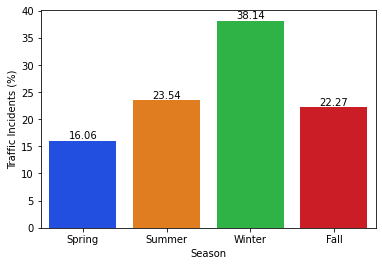

In [191]:
# To draw the distribution of percentage of traffic incidents across different seasons
ax = sns.barplot(x='Season', y='Severity', order = ['spring','summer','fall','winter'], estimator=lambda x: len(x) /len(data) * 100, data=data, palette = 'bright')
ax.set(title='', xlabel = "Season", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Spring','Summer', 'Winter', 'Fall'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

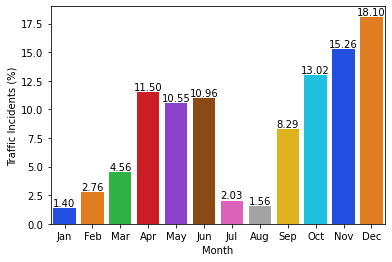

In [193]:
# To draw the distribution of percentage of traffic incidents across different months
ax = sns.barplot(x='Month', y='Month', data=data, estimator=lambda x: len(x) / len(data) * 100 , palette = 'bright')
ax.set(title='', xlabel="Month", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

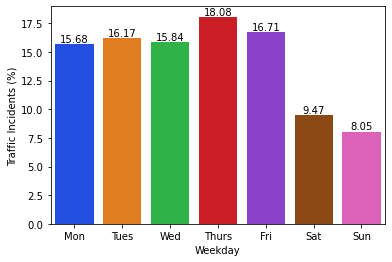

In [195]:
# To draw the distribution of percentage of traffic incidents across different weekdays
ax = sns.barplot(x='Weekday', y='Weekday', data=data, estimator=lambda x: len(x) / len(data) * 100, palette = 'bright')
ax.set(title='', xlabel = "Weekday", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs','Fri','Sat','Sun'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

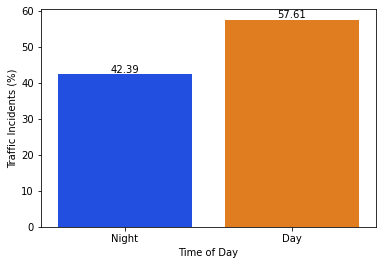

In [198]:
# To draw the distribution of percentage of traffice incidents across time of day (day/night)
ax = sns.barplot(x='Sunrise_Sunset', y='Severity', data=data, estimator=lambda x: len(x) / len(data) * 100 , palette ='bright')
ax.set(title='', xlabel="Time of Day", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

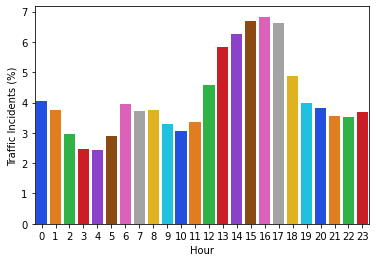

In [197]:
# To draw the distribution of percentage of traffice incidents across different time of day
ax = sns.barplot(x=data['Start_Time'].dt.hour, y='Severity', data=data, estimator=lambda x: len(x) / len(data) * 100, palette = 'bright')
ax.set(title='', xlabel="Hour", ylabel="Traffic Incidents (%)")
plt.show()

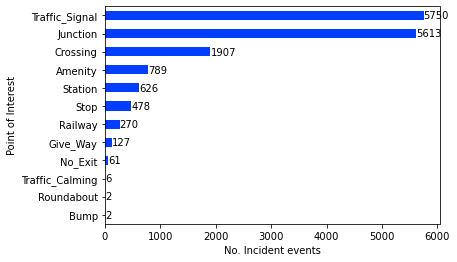

In [220]:
# To draw distribution of accidents across different point of interests
data_poi = pd.DataFrame()
poi = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
poi_counts = data[poi].melt()
poi_counts = pd.crosstab(index=poi_counts['variable'], columns=poi_counts['value'])
poi_counts = poi_counts[1].sort_values(ascending=True)
ax = poi_counts.plot.barh(cmap=ListedColormap(sns.color_palette('bright')))
ax.set(title='', xlabel="No. Incident events", ylabel="Point of Interest")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.0f")
plt.show()    

[Text(0.5, 1.0, ''),
 Text(0.5, 0, 'Top five cities'),
 Text(0, 0.5, 'No. Incident events')]

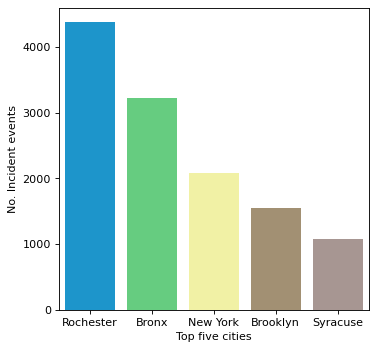

In [260]:
city_data = pd.DataFrame(data['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})
top_5_cities = pd.DataFrame(city_data.head(5))
fig, ax = plt.subplots(figsize = (5,5), dpi = 80)
ax=sns.barplot(y=top_5_cities['Cases'], x=top_5_cities['City'], palette='terrain')
ax.set(title='', xlabel="Top five cities", ylabel="No. Incident events")

<AxesSubplot:>

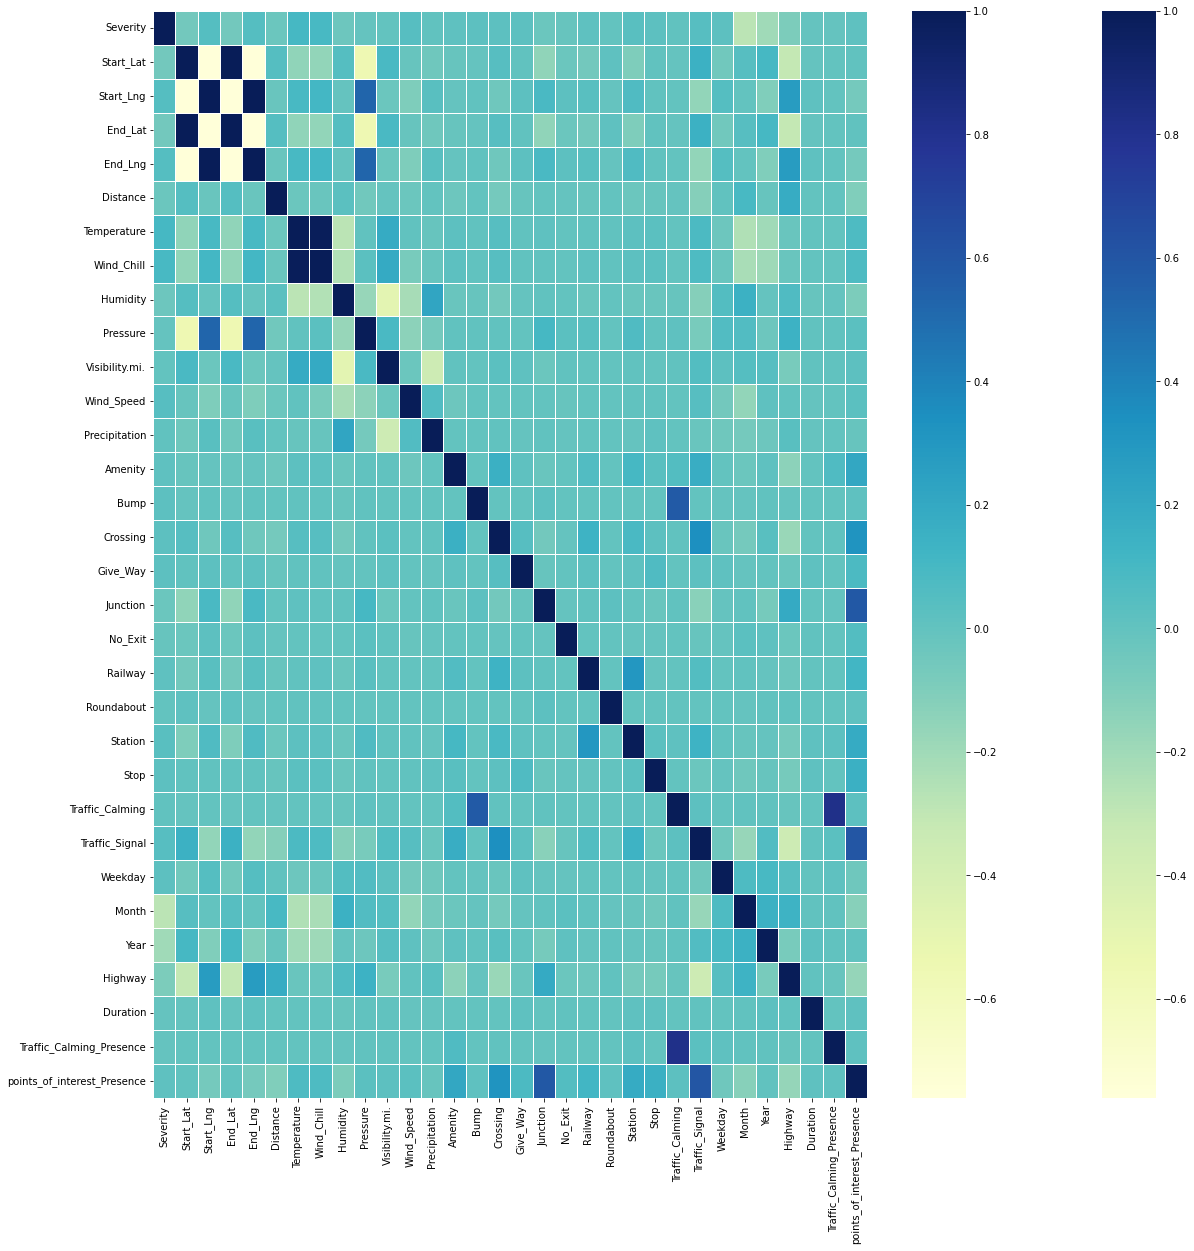

In [259]:
# To draw a correlation matrix
fig, ax = plt.subplots(figsize=(20,20))
corr=data.corr()
sns.heatmap(corr,annot=False,linewidths=.5,cmap="YlGnBu", ax=ax)
corr=data.corr()
sns.heatmap(corr,annot=False,linewidths=.5,cmap="YlGnBu", ax=ax)